### Brief explanation about Composite Experiment
Composite experiments framework consists of 2 experiment classes : `ParallelExperiment` and `BatchExperiment`. Theses classes literally provide a way to perform a single composite experiment which made up of many component experiments. 
* ParallelExperiment is suitable when running experiments each defined on independent subset of device qubits. For example, when we perform a RB experiment on qubit0, qubit1, qubit2, it would be time saving to make each experiments as a single parallelexperiment which generate only 1 job by combining all the sub experiment circuits into circuits which run the component gates in parallel on the respective qubits whereas if they were made as an independent experiments, 3 jobs would have been generated and 3 queue times.
* Batchexperiment is a single large job constists of all the circuits from sub experiments in series. If sub experiments are run on overlapping qubtis, parallelexperiment is impossible and we need to use batchexperiment. For example, if we want to run 2qubit RB experiments on qubit pair (1,2) and (1,4) we have to make these sub experiments performed serially by composing a batchexperiment. Again, it would save queue time.

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import time

from qiskit.providers.aer import QasmSimulator


In [5]:
import numpy as np
from qiskit_experiments.library import StandardRB
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment
from qiskit_experiments.library.randomized_benchmarking import RBUtils
import qiskit.circuit.library as circuits
import qiskit.ignis.verification.randomized_benchmarking as rb

# For simulation
from qiskit.providers.aer import AerSimulator


In [2]:
from qiskit import IBMQ
IBMQ.save_account('befca44219528a564b7f4d3f53707de8985c22fb7b8c969ef2728c830de7c612716e76f41fbc0a52d65f63e71a3a2437948befd3042b1ffab4ced07d573192f1')
IBMQ.load_account()
IBMQ.providers()


configrc.store_credentials:WARNING:2021-12-01 14:58:54,461: Credentials already present. Set overwrite=True to overwrite.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='skku', project='squirl')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='skku', project='skku-graduate')>]

We will choose a backend to characterize and use configuration to check the reported backend's property. We will do 1 and 2 qubit gate RB, and for 2 qubit gate RB information about qubit coupling and gate length are necessary to find out preferred direction of cx gate .
In addition, knowing maximum number of experiments per job is helpful to construct possible job.

In [3]:
#provider=IBMQ.providers()[1]
provider = IBMQ.get_provider(hub='ibm-q-skku', group='skku', project='squirl')
#backend=provider.backend.ibmq_lima
backend = provider.get_backend('ibmq_lima')

# get the basic feautures including qubit number of the backend.
config = backend.configuration()
backend_job_limit=backend.job_limit()

print("{0} is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}.{6} are the list of connected qubits."
      "{7} can handle maximum {8} circuits(experiments) per job."
      "Maximum number of active job i can have on it (cocurrent jobs that a user is able to submit to a backend) is {9}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates,
                config.coupling_map,
               config.backend_name,
               config.max_experiments,
               backend_job_limit.maximum_jobs))

ibmq_lima is on version 1.0.25. It has 5 qubits. It does not support OpenPulse programs. The basis gates supported on this device are ['id', 'rz', 'sx', 'x', 'cx', 'reset'].[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]] are the list of connected qubits.ibmq_lima can handle maximum 100 circuits(experiments) per job.Maximum number of active job i can have on it (cocurrent jobs that a user is able to submit to a backend) is None.


In [6]:
# Before sending a job to the backend, check how many pending jobs are there
# to estimate how long the experiment will take.
status=backend.status()
jobs_in_queue=status.pending_jobs
print(jobs_in_queue)

29


In [4]:
print(backend.properties().to_dict()['gates'])

[{'qubits': [0], 'gate': 'id', 'parameters': [{'date': datetime.datetime(2021, 11, 30, 14, 38, 45, tzinfo=tzlocal()), 'name': 'gate_error', 'unit': '', 'value': 0.00019502007641518078}, {'date': datetime.datetime(2021, 11, 30, 15, 24, 29, tzinfo=tzlocal()), 'name': 'gate_length', 'unit': 'ns', 'value': 35.55555555555556}], 'name': 'id0'}, {'qubits': [1], 'gate': 'id', 'parameters': [{'date': datetime.datetime(2021, 11, 30, 14, 43, 54, tzinfo=tzlocal()), 'name': 'gate_error', 'unit': '', 'value': 0.0003779981853455953}, {'date': datetime.datetime(2021, 11, 30, 15, 24, 29, tzinfo=tzlocal()), 'name': 'gate_length', 'unit': 'ns', 'value': 35.55555555555556}], 'name': 'id1'}, {'qubits': [2], 'gate': 'id', 'parameters': [{'date': datetime.datetime(2021, 11, 30, 14, 38, 45, tzinfo=tzlocal()), 'name': 'gate_error', 'unit': '', 'value': 0.00021634787337932064}, {'date': datetime.datetime(2021, 11, 30, 15, 24, 29, tzinfo=tzlocal()), 'name': 'gate_length', 'unit': 'ns', 'value': 35.55555555555556

## Running 1 qubit RB experiment on multiple qubit

In [15]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
#qubits = [0:config.n_qubits]
qubits=range(config.n_qubits)

# Run an RB experiment on every qubit in the backend.
exps = [StandardRB([i], lengths, num_samples=num_samples, seed=seed + i)
       for i in qubits]
par_exp=ParallelExperiment(exps)
start=time.time()
par_expdata=par_exp.run(backend).block_for_results()
duration=time.time()-start
par_expdata.save()
par_results=par_expdata.analysis_results()

# View result data
for result in par_results:
    print(result)
    print("\nextra:")
    print(result.extra)
   

You can view the experiment online at https://quantum-computing.ibm.com/experiments/74671208-3e0c-4057-8e93-228dfd2db980
DbAnalysisResultV1
- name: StandardRB
- value: 80005ac6-c198-4758-bc9c-21540261f05a
- device_components: ['Q0']
- verified: False

extra:
{}
DbAnalysisResultV1
- name: StandardRB
- value: 5f84c94d-75f3-4973-94fe-766c131cfe41
- device_components: ['Q1']
- verified: False

extra:
{}
DbAnalysisResultV1
- name: StandardRB
- value: db743fba-1ffc-4e62-aac8-5bd9c865f798
- device_components: ['Q2']
- verified: False

extra:
{}
DbAnalysisResultV1
- name: StandardRB
- value: 34242395-8cd8-4ae1-a9ea-99adfa5a2acb
- device_components: ['Q3']
- verified: False

extra:
{}
DbAnalysisResultV1
- name: StandardRB
- value: 657080b7-6c2e-43de-8260-6b6f9bd73dfd
- device_components: ['Q4']
- verified: False

extra:
{}


In [16]:
print(duration)

877.6774995326996


In [411]:
# Check how long the experiment took 
#since RB takes quite a long time 
#It is good to know the timescale of the experiment.

print(duration)

1436.216049671173


### Viewing sub experiment data

Component experiment 0


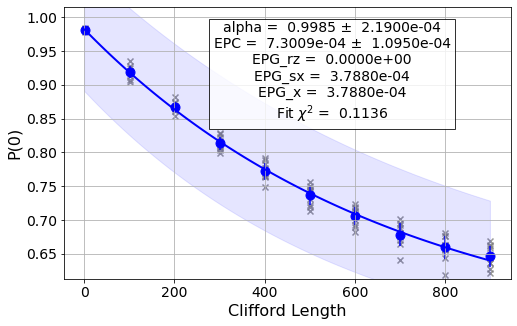

DbAnalysisResultV1
- name: @Parameters_RBAnalysis
- value: [0.46828341 0.99853983 0.51406031] ± [0.04557496 0.000219   0.04581386]
- χ²: 0.11362396283915219
- extra: <3 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9985398294649062 ± 0.00021900419974582927
- χ²: 0.11362396283915219
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0007300852675469205 ± 0.00010950209987291464
- χ²: 0.11362396283915219
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: EPG_rz
- value: 0.0
- χ²: 0.11362396283915219
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: EPG_sx
- value: 0.0003787957135311833
- χ²: 0.11362396283915219
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: EPG_x
- value: 0.0003787957135311833
- χ²: 0.11362396283915219
- device_components: ['Q0']
- verified: False
Component experiment 1


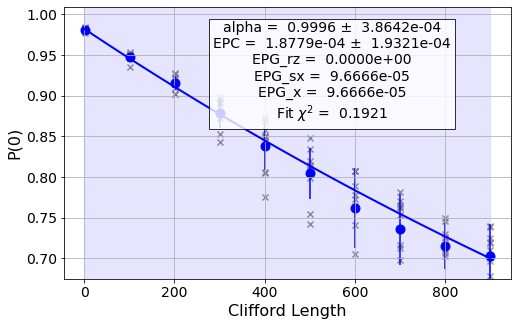

DbAnalysisResultV1
- name: @Parameters_RBAnalysis
- value: [9.81957678e-01 9.99624422e-01 6.62242091e-22] ± [9.13634722e-01 3.86424983e-04 9.14303374e-01]
- χ²: 0.19209106353733274
- extra: <3 items>
- device_components: ['Q1']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9996244221144784 ± 0.0003864249830825458
- χ²: 0.19209106353733274
- device_components: ['Q1']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0001877889427607804 ± 0.0001932124915412729
- χ²: 0.19209106353733274
- device_components: ['Q1']
- verified: False
DbAnalysisResultV1
- name: EPG_rz
- value: 0.0
- χ²: 0.19209106353733274
- device_components: ['Q1']
- verified: False
DbAnalysisResultV1
- name: EPG_sx
- value: 9.666566937395333e-05
- χ²: 0.19209106353733274
- device_components: ['Q1']
- verified: False
DbAnalysisResultV1
- name: EPG_x
- value: 9.666566937395333e-05
- χ²: 0.19209106353733274
- device_components: ['Q1']
- verified: False
Component experiment 2


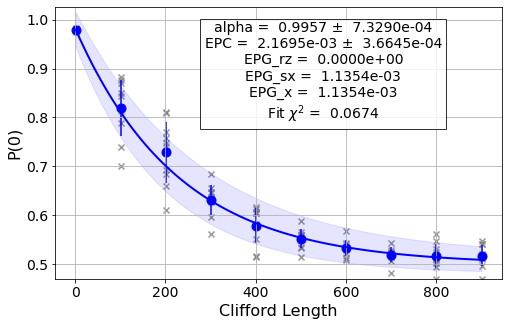

DbAnalysisResultV1
- name: @Parameters_RBAnalysis
- value: [0.4821146  0.995661   0.49943929] ± [0.01781194 0.0007329  0.01796311]
- χ²: 0.06736151747459192
- extra: <3 items>
- device_components: ['Q2']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9956610035519317 ± 0.0007328956240456563
- χ²: 0.06736151747459192
- device_components: ['Q2']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.002169498224034172 ± 0.00036644781202282815
- χ²: 0.06736151747459192
- device_components: ['Q2']
- verified: False
DbAnalysisResultV1
- name: EPG_rz
- value: 0.0
- χ²: 0.06736151747459192
- device_components: ['Q2']
- verified: False
DbAnalysisResultV1
- name: EPG_sx
- value: 0.0011353633186466086
- χ²: 0.06736151747459192
- device_components: ['Q2']
- verified: False
DbAnalysisResultV1
- name: EPG_x
- value: 0.0011353633186466086
- χ²: 0.06736151747459192
- device_components: ['Q2']
- verified: False
Component experiment 3


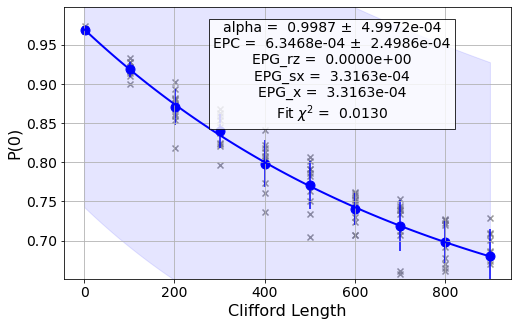

DbAnalysisResultV1
- name: @Parameters_RBAnalysis
- value: [0.42582127 0.99873064 0.54401466] ± [0.11337512 0.00049972 0.11364948]
- χ²: 0.01295998112206832
- extra: <3 items>
- device_components: ['Q3']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9987306404555129 ± 0.0004997217000035849
- χ²: 0.01295998112206832
- device_components: ['Q3']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0006346797722435737 ± 0.00024986085000179245
- χ²: 0.01295998112206832
- device_components: ['Q3']
- verified: False
DbAnalysisResultV1
- name: EPG_rz
- value: 0.0
- χ²: 0.01295998112206832
- device_components: ['Q3']
- verified: False
DbAnalysisResultV1
- name: EPG_sx
- value: 0.0003316299061615936
- χ²: 0.01295998112206832
- device_components: ['Q3']
- verified: False
DbAnalysisResultV1
- name: EPG_x
- value: 0.0003316299061615936
- χ²: 0.01295998112206832
- device_components: ['Q3']
- verified: False
Component experiment 4


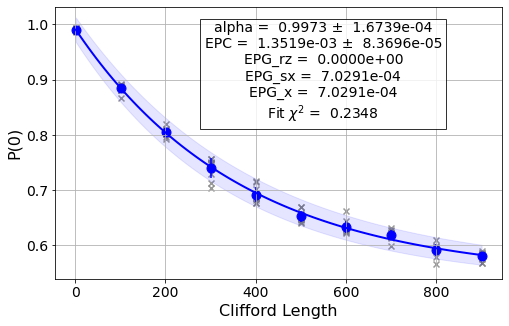

DbAnalysisResultV1
- name: @Parameters_RBAnalysis
- value: [0.44818464 0.99729623 0.54355508] ± [0.010979   0.00016739 0.01111801]
- χ²: 0.23479815938225196
- extra: <3 items>
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9972962315235716 ± 0.00016739105587426262
- χ²: 0.23479815938225196
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.001351884238214196 ± 8.369552793713131e-05
- χ²: 0.23479815938225196
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: EPG_rz
- value: 0.0
- χ²: 0.23479815938225196
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: EPG_sx
- value: 0.0007029099881834062
- χ²: 0.23479815938225196
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: EPG_x
- value: 0.0007029099881834062
- χ²: 0.23479815938225196
- device_components: ['Q4']
- verified: False
[DbAnalysisResultV1(name=@Parameters_RBAnalysis, value=FitVal(value=arr

In [482]:
# Print sub-experiment data
# sub_result is a list consists of 6 analysis results(parameter, alpha, EPC, EPG rz, EPG sx, EPG x) components
# sub_results is a list consists of 5*6 analysis results components
# sub_results_list is a 2 dimensional list consists of list components where each list components have 6 analysis data
sub_results=[]
sub_results_list=[]
for i in range(par_exp.num_experiments):
    print(f"Component experiment {i}")
    sub_data = par_expdata.component_experiment_data(i)
    display(sub_data.figure(0))
    sub_result=sub_data.analysis_results()
    sub_results += sub_result
    sub_results_list.append(sub_result)
    for result in sub_result:
        print(result)
print('=========================================================')
print(sub_results)
print('==========================================================')
print(sub_results_list)

## Running 2qubit RB experiment on native qubit pair.


The IBM Q experience uses the cross-resonance interaction as the basis for the cx-gate. Generally,a qubit with a higher frequency becomes controlling one and lower frequency target one since cross resonance is stronger in this way.Therefore CNOT has a preferred direction depending of qubit frequency. 
However there are some exceptions to this rule. 
Therefore, we will choose cx direction referencing the gate length. CNOT with native direction takes slightly shorter time since there is one extra single qubit gate in the opposite direction to make opposite direction of CNOT also possible for the backend. 
The function `native_cnot` will render you the native direction of cnot which has shorter gate length to perform 2qubit RB experiemnt.
You can check the gate length of CNOTs for both direction in [IBM Quantum Service](https://quantum-computing.ibm.com/services?services=systems). Though gate length of both directions are diffrent the error rates are same. This is because single qubit gate errors are typically 1-2 orders of magnitude lower than the CNOT gate errors and this fact is not reflected.
In this guide, let's also consider the native direction!

In [8]:
coupled_qubit=config.coupling_map
def native_cnot(coupled_qubit):
    native_cnot=[]
    coupling_map=list(map(tuple, coupled_qubit))
    print(f'coupling_map={coupling_map}')
    print('\n')
        
    for i in range(0, len(coupling_map)-1):
        for j in range(i+1, len(coupling_map)):        
            if coupling_map[i][0]==coupling_map[j][1] and coupling_map[i][1]==coupling_map[j][0]:                
                i_direction=backend.properties().gate_length('cx',(coupling_map[i][0],coupling_map[i][1]))
                j_direction=backend.properties().gate_length('cx',(coupling_map[j][0],coupling_map[j][1]))
                print(f'cx{coupling_map[i]} takes {i_direction}sec')
                print(f'cx{coupling_map[j]} takes {j_direction}sec')
                print('----------------------------------------------')
                if i_direction > j_direction:
                    native_cnot.append(coupling_map[j])
                else:
                    native_cnot.append(coupling_map[i])       
    return native_cnot

native_cnot=native_cnot(coupled_qubit)        
                
print(native_cnot)     

coupling_map=[(0, 1), (1, 0), (1, 2), (1, 3), (2, 1), (3, 1), (3, 4), (4, 3)]


cx(0, 1) takes 3.0577777777777775e-07sec
cx(1, 0) takes 3.413333333333333e-07sec
----------------------------------------------
cx(1, 2) takes 3.342222222222222e-07sec
cx(2, 1) takes 2.9866666666666664e-07sec
----------------------------------------------
cx(1, 3) takes 4.977777777777778e-07sec
cx(3, 1) takes 4.622222222222222e-07sec
----------------------------------------------
cx(3, 4) takes 5.191111111111111e-07sec
cx(4, 3) takes 4.835555555555555e-07sec
----------------------------------------------
[(0, 1), (2, 1), (3, 1), (4, 3)]


We will construct 2 qubit gate (cx gate) RB experiment in native direction with the ordered pairs obatained above. 

In [11]:
# Make a list of 2qubit gate RB experiments on native CNOT direction
lengths_2q=np.arange(1,200,30)
exps_2q =[]
for i in range(0,len(native_cnot)):
    exps_2q.append(StandardRB(native_cnot[i],lengths_2q, num_samples=num_samples, seed=seed+i))

print(exps_2q)


[<qiskit_experiments.library.randomized_benchmarking.rb_experiment.StandardRB object at 0x000002257F115460>, <qiskit_experiments.library.randomized_benchmarking.rb_experiment.StandardRB object at 0x000002257F115B20>, <qiskit_experiments.library.randomized_benchmarking.rb_experiment.StandardRB object at 0x000002257F145D60>, <qiskit_experiments.library.randomized_benchmarking.rb_experiment.StandardRB object at 0x000002257F145C10>]


Before running the 2qubit RB, use EPG data of 1 qubit RB experiment to ensure correct 2 qubit EPG computation.

In [499]:
# Make a 2dimensional list 'epg_1q' which constists of lists
# each list consists of 2*6 analysis data of paired qubit tuple
N=native_cnot
epg_1q=[]

for i in range(len(N)):
    epg_1q_pair=par_expdata.component_experiment_data(N[i][0]).analysis_results()+par_expdata.component_experiment_data(N[i][1]).analysis_results()
    epg_1q.append(epg_1q_pair)
    
print(epg_1q)

[[DbAnalysisResultV1(name=@Parameters_RBAnalysis, value=FitVal(value=array([0.46828341, 0.99853983, 0.51406031]), stderr=array([0.04557496, 0.000219  , 0.04581386]), unit=None), device_components=[<Qubit(Q0)>], experiment_id=f38741e2-ac11-43e6-af43-c52bdd02ec30, result_id=94c82971-50f6-4b17-b041-12885935bb15, chisq=0.11362396283915219, quality=None, verified=False, extra={'popt_keys': ['a', 'alpha', 'b'], 'dof': 7, 'covariance_mat': array([[ 2.07707739e-03,  9.75503551e-06, -2.08634946e-03],
       [ 9.75503551e-06,  4.79628395e-08, -9.83401327e-06],
       [-2.08634946e-03, -9.83401327e-06,  2.09890982e-03]])}, tags=[], service='f38741e2-ac11-43e6-af43-c52bdd02ec30'), DbAnalysisResultV1(name=alpha, value=FitVal(value=0.9985398294649062, stderr=0.00021900419974582927, unit=None), device_components=[<Qubit(Q0)>], experiment_id=f38741e2-ac11-43e6-af43-c52bdd02ec30, result_id=54824b2d-5f5a-4d2d-9900-2f0112ae8287, chisq=0.11362396283915219, quality=None, verified=False, extra={}, tags=[], 

In [501]:
# give 1qubit EPG data to 2qubit RB experiment as analysis option
i=0
for RBi in exps_2q:
    RBi.set_analysis_options(epg_1_qubit=epg_1q[i])
    i += 1
# Run 2qubit RB experiments on coupled qubit in native directions
# RB2qResults is a 2dimesional list consists of
# RB2qResult which is a list consists of 4 analysis data(Parameter analysis, alpha, EPC, EPG_cx)
RB2qResults=[]
for RBexp in exps_2q:
    RBexpdata=RBexp.run(backend).block_for_results() 
    RB2qResult=RBexpdata.analysis_results()
    RB2qResults.append(RB2qResult)
print(RB2qResults)


[[DbAnalysisResultV1(name=@Parameters_RBAnalysis, value=FitVal(value=array([0.68950887, 0.98639989, 0.25230721]), stderr=array([0.03315398, 0.00176927, 0.03370795]), unit=None), device_components=[<Qubit(Q0)>, <Qubit(Q1)>], experiment_id=e6691070-03d8-49fb-8ad2-971bef387a67, result_id=5b80c0c4-4457-4950-a04f-f09d764301da, chisq=0.09193624812729034, quality=None, verified=False, extra={'popt_keys': ['a', 'alpha', 'b'], 'dof': 4, 'covariance_mat': array([[ 1.09918613e-03,  4.95582159e-05, -1.07796704e-03],
       [ 4.95582159e-05,  3.13030196e-06, -5.42405307e-05],
       [-1.07796704e-03, -5.42405307e-05,  1.13622617e-03]])}, tags=[], service='e6691070-03d8-49fb-8ad2-971bef387a67'), DbAnalysisResultV1(name=alpha, value=FitVal(value=0.9863998857678536, stderr=0.00176926593775564, unit=None), device_components=[<Qubit(Q0)>, <Qubit(Q1)>], experiment_id=e6691070-03d8-49fb-8ad2-971bef387a67, result_id=6662c038-878a-4097-b4b7-f2f4e01054ec, chisq=0.09193624812729034, quality=None, verified=Fal

In [542]:
# Compare the computed EPG of the cx gate with the backend's recorded cx gate error:
for i in range(len(native_cnot)):
    expected_epg = RBUtils.get_error_dict_from_backend(backend, native_cnot[i])[(native_cnot[i], 'cx')]
    exp_2q_epg = RB2qResults[i][3]
    
    print("Backend's reported EPG of the cx gate:", expected_epg)
    print("Experiment computed EPG of the cx gate:", exp_2q_epg)
    print('------------------------------------------------------')

Backend's reported EPG of the cx gate: 0.00678562024585011
Experiment computed EPG of the cx gate: DbAnalysisResultV1
- name: EPG_cx
- value: 0.005656407102519014
- χ²: 0.09193624812729034
- device_components: ['Q0', 'Q1']
- verified: False
------------------------------------------------------
Backend's reported EPG of the cx gate: 0.027254504118058243
Experiment computed EPG of the cx gate: DbAnalysisResultV1
- name: EPG_cx
- value: 0.0035767934745978736
- χ²: 0.0994869649638196
- device_components: ['Q1', 'Q2']
- verified: False
------------------------------------------------------
Backend's reported EPG of the cx gate: 0.012372152452117202
Experiment computed EPG of the cx gate: DbAnalysisResultV1
- name: EPG_cx
- value: 0.012361111224210611
- χ²: 0.017306043870124955
- device_components: ['Q1', 'Q3']
- verified: False
------------------------------------------------------
Backend's reported EPG of the cx gate: 0.01702304697847834
Experiment computed EPG of the cx gate: DbAnalysis

From this part, This is what i have tried but failed due to errors

In [516]:
# Batchexperiment shows error 
bat_exps_2q=BatchExperiment([exps_2q[0],exps_2q[1]])
bat_expdata_2q=bat_exps_2q.run(backend).block_for_results()
bat_results_2q=bat_expdata_2q.analysis_results()
for result in bat_results_2q:
    print(result)

IBMQBackendApiError: 'Error submitting job: "HTTPSConnectionPool(host=\'api-qcon.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q-skku/Groups/skku/Projects/squirl/Jobs (Caused by NewConnectionError(\'<urllib3.connection.HTTPSConnection object at 0x0000020A6F0101F0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed\'))"'

In [6]:
# Running 7experiments with 'for' loop
# it takes too much time compared with parallelexp 
# It consists of 7 experiments -> 7jobs each go to the backend 

lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = config.n_qubits

# Run a 1-qubit RB expriment on every qubit 
# to determine the epg_1q
expdata_1q = {}
epg_1q = []
lengths_1_qubit = np.arange(1, 1000, 100)
for qubit in range(qubits):
    exp = StandardRB([qubit], lengths_1_qubit, num_samples=num_samples, seed=seed)
    expdata = exp.run(backend).block_for_results()
    expdata_1q[qubit] = expdata
    epg_1q += expdata.analysis_results()
    
for result in epg_1q:
    print(result)

In [21]:
#ParallelExperiment on 7qubits dont work! : long job error!
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = range(config.n_qubits)

# Run a parallel 1-qubit RB experiment on every qubit
exps_1q = [StandardRB([i], lengths, num_samples=num_samples, seed=seed+i)
        for i in qubits]
par_exp_1q = ParallelExperiment(exps_1q)
start=time.time()
par_expdata_1q = par_exp_1q.run(backend).block_for_results()
duration=time.time()-start
par_results_1q = par_expdata_1q.analysis_results()

# View result data
for result in par_results_1q:
    print(result)
    print("\nextra:")
    print(result.extra)
print(duration)

IBMQBackendApiError: "Error submitting job: '403 Client Error: Forbidden for url: https://api-qcon.quantum-computing.ibm.com/api/Network/ibm-q-skku/Groups/skku/Projects/squirl/Jobs/6196f4366254dd83fd8661f1/jobDataUploaded. Your job is too long., Error code: 3248.'"

In [405]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.18.3', 'qiskit-aer': '0.9.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.18.0', 'qiskit-aqua': '0.9.5', 'qiskit': '0.32.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}